In [1]:
cd ..

/home/araxal/coursework


In [2]:
import numpy as np
import torch
from torch import nn
from utils.genre_classification import evaluate, executor
from utils.decade_classification import feature_preparator
from utils.genre_classification.random_features_slicer import random_features_slicer
from utils.genre_classification.plot_metrics import plot_metrics
from models.genre_classification.FeedForwardModel import FeedForwardModel
from utils.genre_classification.plot_confusion_matrix import plot_confusion_matrix

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
BATCH_SIZE = 8
NUM_CLASSES = 4
DEVICE = torch.device('cuda')

In [5]:
%%time
train_data_loader, val_data_loader, test_data_loader, idx_to_label = feature_preparator(
    'features/decade_classification/mfcc24-zcr-sc-sr-sf-chr.p',
    BATCH_SIZE,
    transform=random_features_slicer,
    normalize=True
)

def transform_idx_to_label(x):
    return idx_to_label[x]

CPU times: user 364 ms, sys: 161 ms, total: 524 ms
Wall time: 525 ms


In [6]:
next(iter(train_data_loader))[0].shape

torch.Size([8, 256, 40])

In [7]:
train_labels = []
val_labels = []
test_labels = []

for x, label in train_data_loader:
    train_labels.append(label)

for x, label in val_data_loader:
    val_labels.append(label)

for x, label in test_data_loader:
    test_labels.append(label)

print('Train', np.unique(torch.cat(train_labels).numpy(), return_counts=True))
print('Val', np.unique(torch.cat(val_labels).numpy(), return_counts=True))
print('Test', np.unique(torch.cat(test_labels).numpy(), return_counts=True))
print(idx_to_label)

Train (array([0, 1, 2, 3]), array([245, 238, 224, 245]))
Val (array([0, 1, 2, 3]), array([51, 49, 48, 52]))
Test (array([0, 1, 2, 3]), array([52, 50, 47, 51]))
{0: '1990', 1: '2000', 2: '2010', 3: 'old'}


## Перцептрон

 51%|█████     | 51/100 [00:31<00:30,  1.62it/s]

Early stop!


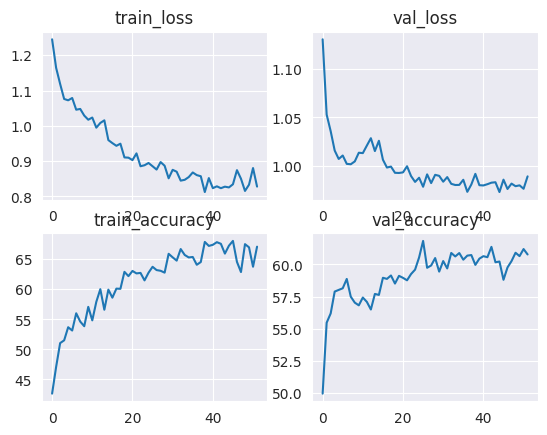

In [8]:
ff_simple_model = FeedForwardModel(256 * 40, NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, ff_simple_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(15,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.64      0.67      0.65        52
        2000       0.52      0.62      0.56        50
        2010       0.50      0.39      0.44        46
         old       0.78      0.73      0.75        52

    accuracy                           0.61       200
   macro avg       0.61      0.60      0.60       200
weighted avg       0.61      0.61      0.61       200



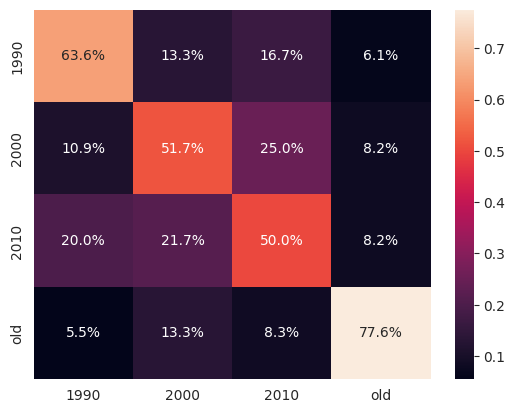

In [9]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, ff_simple_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

## Свертка по времени

 31%|███       | 31/100 [00:47<01:46,  1.54s/it]

Early stop!


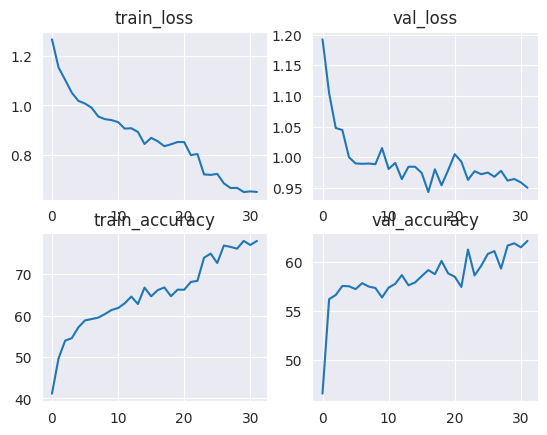

In [10]:
from models.genre_classification.Conv1Model import Conv1Model

conv_1_model = Conv1Model(NUM_CLASSES, time_size=256, feature_size=40).to(DEVICE)
train_progress, val_progress = executor(DEVICE, conv_1_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(15,  0.01))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.64      0.57      0.60        53
        2000       0.44      0.49      0.47        49
        2010       0.55      0.60      0.57        45
         old       0.88      0.83      0.85        53

    accuracy                           0.62       200
   macro avg       0.63      0.62      0.62       200
weighted avg       0.64      0.62      0.63       200



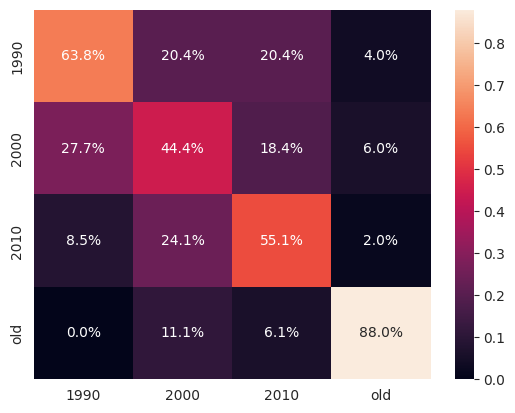

In [11]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, conv_1_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

## Свертка по фичам

 48%|████▊     | 48/100 [01:27<01:34,  1.82s/it]

Early stop!


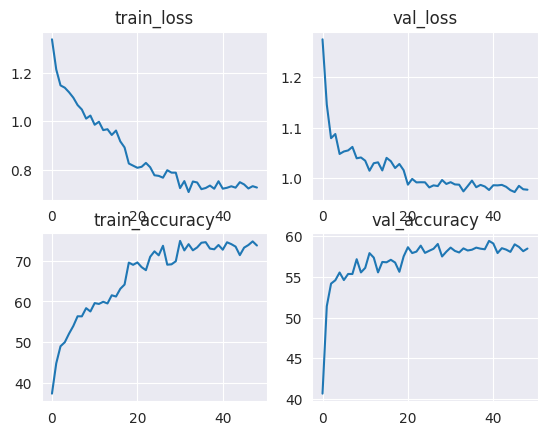

In [12]:
from models.genre_classification.Conv2Model import Conv2Model

conv_2_model = Conv2Model(NUM_CLASSES, 40, 256).to(DEVICE)
train_progress, val_progress = executor(DEVICE, conv_2_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(15,  0.01))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.67      0.57      0.61        53
        2000       0.44      0.54      0.49        50
        2010       0.55      0.39      0.46        46
         old       0.67      0.80      0.73        51

    accuracy                           0.58       200
   macro avg       0.58      0.58      0.57       200
weighted avg       0.58      0.58      0.58       200



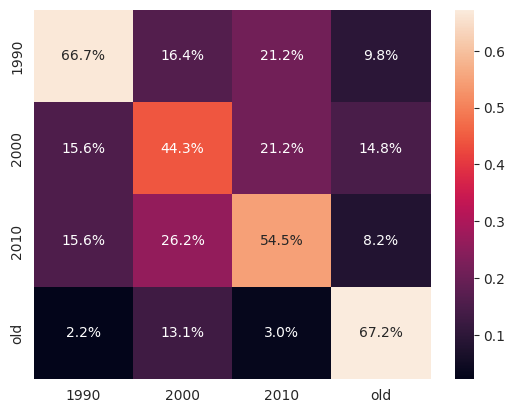

In [13]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, conv_2_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

## LSTM

 50%|█████     | 50/100 [00:48<00:48,  1.02it/s]

Early stop!


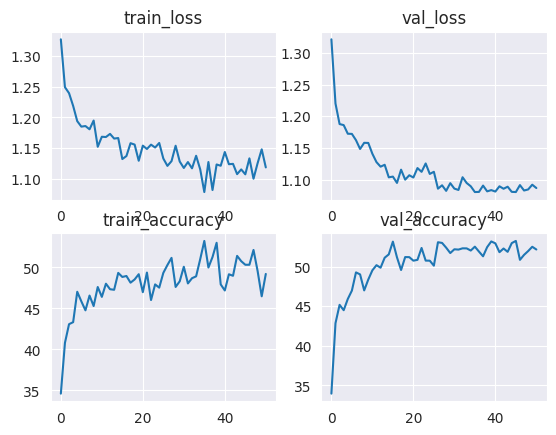

In [14]:
from models.genre_classification.LSTMModel import LSTMModel

lstm_simple_model = LSTMModel(40, 1024, NUM_CLASSES).to(DEVICE)
train_progress, val_progress = executor(DEVICE, lstm_simple_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=1e-4, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(15,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.48      0.52      0.50        50
        2000       0.41      0.49      0.44        49
        2010       0.38      0.31      0.34        48
         old       0.83      0.74      0.78        53

    accuracy                           0.52       200
   macro avg       0.52      0.51      0.52       200
weighted avg       0.53      0.52      0.52       200



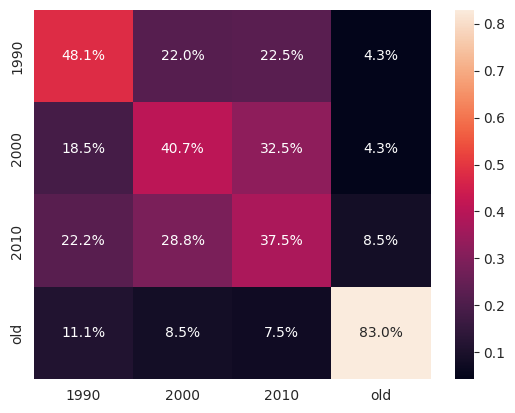

In [15]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, lstm_simple_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

## Свертка по времени и фичам

 52%|█████▏    | 52/100 [00:34<00:31,  1.51it/s]

Early stop!


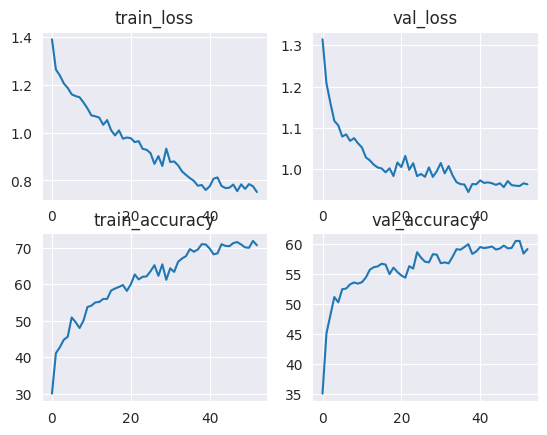

In [16]:
from models.genre_classification.Conv3Model import Conv3Model

conv_3_model = Conv3Model(NUM_CLASSES, 256, 40).to(DEVICE)
train_progress, val_progress = executor(DEVICE, conv_3_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(15,  0.01))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.63      0.68      0.65        53
        2000       0.53      0.60      0.56        50
        2010       0.55      0.46      0.50        46
         old       0.79      0.75      0.77        51

    accuracy                           0.62       200
   macro avg       0.63      0.62      0.62       200
weighted avg       0.63      0.62      0.62       200



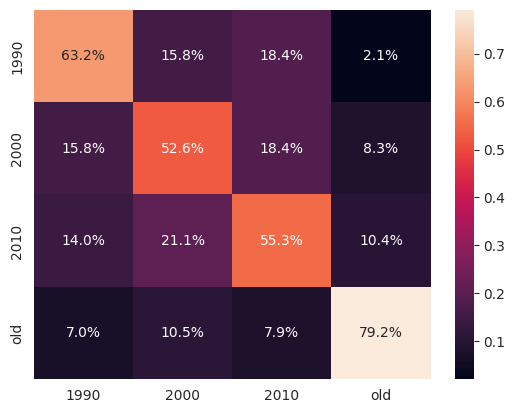

In [17]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, conv_3_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

## Вариации CRNN

 58%|█████▊    | 58/100 [01:00<00:43,  1.04s/it]

Early stop!


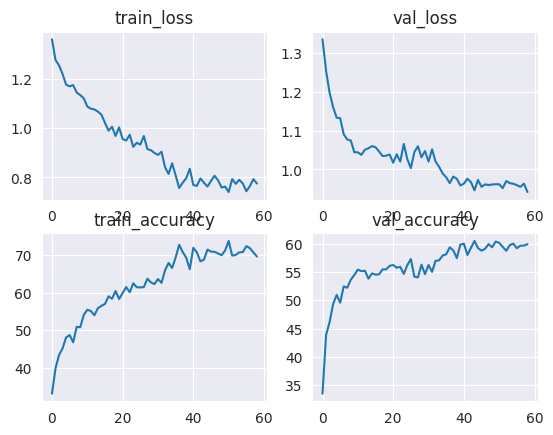

In [18]:
from models.genre_classification.CRNNSimpleModel import CRNNSimpleModel

crnn_model = CRNNSimpleModel(NUM_CLASSES, 40).to(DEVICE)
train_progress, val_progress = executor(DEVICE, crnn_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(15,  0.01))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.55      0.75      0.63        53
        2000       0.55      0.52      0.54        50
        2010       0.48      0.29      0.36        45
         old       0.77      0.79      0.78        52

    accuracy                           0.60       200
   macro avg       0.59      0.59      0.58       200
weighted avg       0.59      0.60      0.59       200



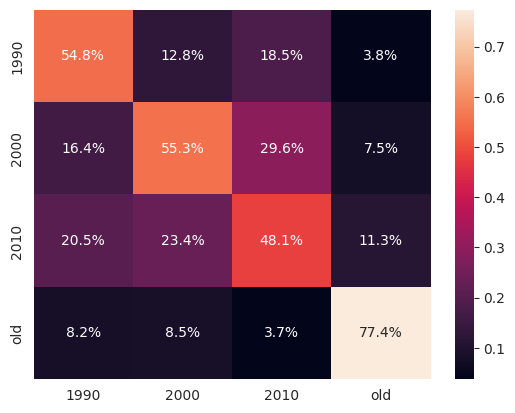

In [19]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, crnn_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

 49%|████▉     | 49/100 [00:47<00:49,  1.02it/s]

Early stop!


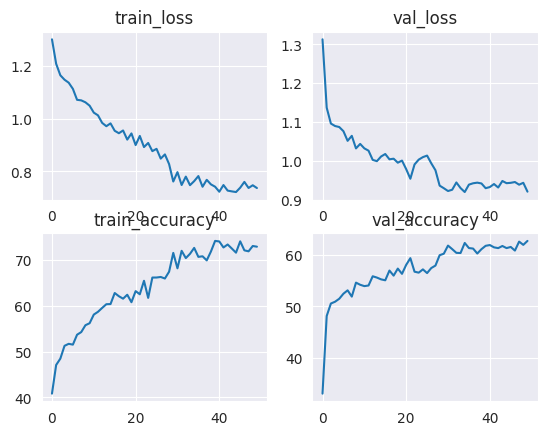

In [20]:
from models.genre_classification.CRNNSimple2Model import CRNNSimple2Model

crnn_model2 = CRNNSimple2Model(NUM_CLASSES, 40).to(DEVICE)
train_progress, val_progress = executor(DEVICE, crnn_model2, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=100, learning_rate=0.0001, weight_decay=0.01, evaluate_per_iteration=10, early_stop_after=(15,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.56      0.62      0.59        52
        2000       0.45      0.39      0.42        51
        2010       0.49      0.45      0.47        44
         old       0.71      0.77      0.74        53

    accuracy                           0.56       200
   macro avg       0.55      0.56      0.55       200
weighted avg       0.56      0.56      0.56       200



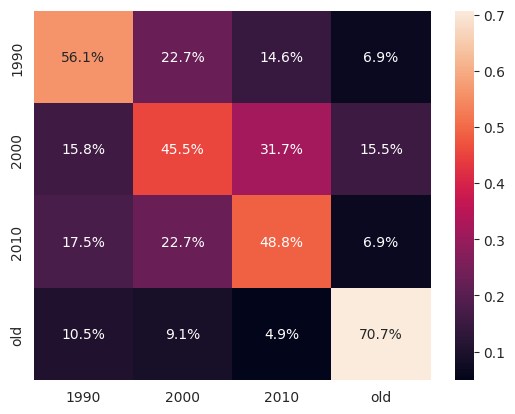

In [21]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, crnn_model2, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

## Трансформер

  1%|          | 1/100 [00:01<02:54,  1.76s/it]

1.3423255697017957 1.3103613379597663


  2%|▏         | 2/100 [00:03<02:53,  1.77s/it]

1.2479291152553398 1.2182633918523789


  3%|▎         | 3/100 [00:05<02:51,  1.76s/it]

1.212103105893656 1.1680210128426551


  4%|▍         | 4/100 [00:07<02:49,  1.76s/it]

1.1895207857885282 1.1399929800629618


  5%|▌         | 5/100 [00:08<02:49,  1.79s/it]

1.1690356450922348 1.132591078877449


  6%|▌         | 6/100 [00:10<02:50,  1.81s/it]

1.170854029034366 1.124756566286087


  7%|▋         | 7/100 [00:12<02:52,  1.85s/it]

1.1553056104844357 1.1283743691444397


  8%|▊         | 8/100 [00:14<02:48,  1.83s/it]

1.1588752925896846 1.1197676181793212


  9%|▉         | 9/100 [00:16<02:44,  1.81s/it]

1.154635513530058 1.1136379078030587


 10%|█         | 10/100 [00:17<02:41,  1.80s/it]

1.1525215536606412 1.1146136689186097


 11%|█         | 11/100 [00:19<02:39,  1.79s/it]

1.142169422462207 1.115091091990471


 12%|█▏        | 12/100 [00:21<02:36,  1.78s/it]

1.139004858601995 1.1106541201472282


 13%|█▎        | 13/100 [00:23<02:35,  1.78s/it]

1.1407612101370548 1.1190722501277923


 14%|█▍        | 14/100 [00:25<02:33,  1.78s/it]

1.135797104915651 1.111146405339241


 15%|█▌        | 15/100 [00:26<02:31,  1.78s/it]

1.132174194860859 1.113521801829338


 16%|█▌        | 16/100 [00:28<02:29,  1.78s/it]

1.1419444660178752 1.1080683055520058


 17%|█▋        | 17/100 [00:30<02:27,  1.78s/it]

1.1308238155701582 1.1143141070008278


 18%|█▊        | 18/100 [00:32<02:25,  1.78s/it]

1.1355597021199073 1.11059412330389


 19%|█▉        | 19/100 [00:34<02:26,  1.80s/it]

1.1363189410762626 1.1133008766174317


 20%|██        | 20/100 [00:35<02:26,  1.83s/it]

1.1378682040366805 1.1077749449014664


 21%|██        | 21/100 [00:37<02:23,  1.82s/it]

1.137829989946189 1.1113994330167771


 22%|██▏       | 22/100 [00:39<02:20,  1.81s/it]

1.1390333746661658 1.1062619167566299


 23%|██▎       | 23/100 [00:41<02:18,  1.80s/it]

1.136150030528798 1.104434099495411


 23%|██▎       | 23/100 [00:43<02:24,  1.87s/it]

1.1329693623951502 1.1063706281781196
Early stop!


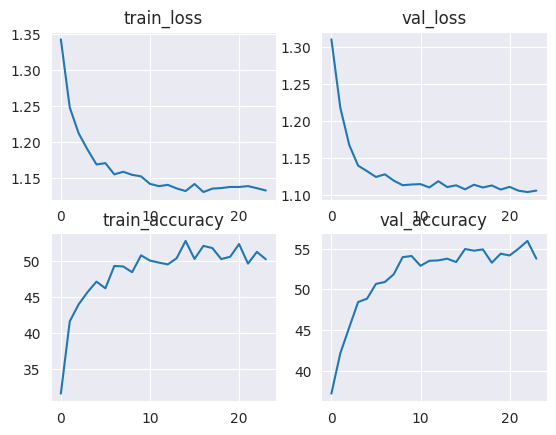

In [22]:
from models.genre_classification.TransformerModel import TransformerModel

transformer_model = TransformerModel(
    input_dim=40,
    num_layers=6,
    output_dim=NUM_CLASSES,
    num_heads=16,
    dropout=0.1,
    hidden_dim=256
).to(DEVICE)
train_progress, val_progress = executor(
    DEVICE,
    transformer_model,
    train_dataloader = train_data_loader,
    val_dataloader=val_data_loader,
    epochs=100,
    learning_rate=0.0001,
    weight_decay=0.1,
    evaluate_per_iteration=15,
    early_stop_after=(15,  0.01),
    print_metrics=True
)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

        1990       0.56      0.45      0.50        51
        2000       0.49      0.49      0.49        49
        2010       0.47      0.56      0.51        48
         old       0.74      0.75      0.74        52

    accuracy                           0.56       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.57      0.56      0.56       200



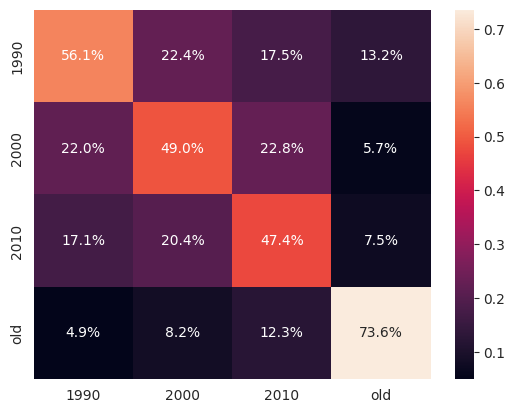

In [23]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, transformer_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)